In [9]:
import rqdatac as rq
from rqdatac import *
rq.init()

In [83]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout,Reshape
from keras.models import Sequential
from keras.optimizers import SGD,Adam,Adadelta
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.ensemble import RandomForestClassifier

from matplotlib.ticker import AutoLocator

In [3]:
def rf():
    param_test1 = {'n_estimators':[10, 30, 50, 70]}
    clf = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt' ,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
    return clf

def ann():
    model = Sequential()
    model.add(Dense(31, activation = 'relu', input_shape = (31, )))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation = 'relu'))
    model.add(Dense(2, activation = 'softmax', bias_regularizer=regularizers.l1(0.00001)))
    adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-06)
    model.compile(loss='binary_crossentropy',
              optimizer = adadelta, metrics=['binary_accuracy'])
    return model

def panel_append(p):
    result = []
    r = np.concatenate((np.r_[1:21],np.r_[40:241:20]))
    for m in r:
        rt = (p/p.shift(m)) - 1
        result.append(rt)
    return list(np.array(result).T)

def lstm():
    model = Sequential()
    model.add(LSTM(25, return_sequences = False,
                   input_shape=(240, 1)))  # returns a sequence of vectors of dimension 32
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])
    return model
def sandlize(erd):
    return np.reshape(erd,(erd.shape[0], erd.shape[1], 1))
def lstm_append(p):
    result = []
    r = np.r_[1:241]
    for m in r:
        rt = (p/p.shift(m)) - 1
        result.append(rt)
    return list(np.array(result).T)
def get_return(model, start_date = '20050104', end_date ='20180709', index_name = '399001.XSHE',cost = 0, k = 5):
    valid_inputs =  ['lstm','rf','log','ann']
    if not model in valid_inputs:
        print('illegal input, inputs should be in', valid_inputs)
        return
    if (type(model) != str):
        print('wrong input type, model should be string.')
    else:
        if model == 'lstm':
            returns, dates = get_return_lstm(start_date, end_date, index_name, cost, k)
        if model == 'rf':
            returns, dates = get_return_rf(start_date, end_date, index_name, cost, k)
        if model == 'log':
            returns, dates = get_return_log(start_date, end_date, index_name, cost, k)
        if model == 'ann':
            returns, dates = get_return_ann(start_date, end_date, index_name, cost, k)
    return returns, dates

In [4]:

def get_return_lstm(start_date, end_date, index_name = '399001.XSHE', cost = 0,k = 5):
    index = []
    returns, dates = [],[]
    ics = index_components(index_name)
    ps = get_price(ics, start_date, end_date,frequency = '1d')['close']
    
    for i in np.r_[0:len(ps.index)-1000:250]:
# Get close prices
        p = ps[i:i+1000].dropna(axis = 'columns', how = 'any')
        ics_new = p.columns
        if (len(ics_new) < k*2):
            print(len(ics_new))
            continue
        rt = (p - p.shift(1))/p
        med = rt.median(axis = 1)
        x_all = p.apply(lambda z : lstm_append(z))
        X_train = []
        y_train = []
        for ic in ics_new:
            x = x_all[ic]
            y = (rt[ic] > med) * 1
            X_train += list(x)[241:749]
            y_train += list(y)[242:750]
        y_train_oh = keras.utils.to_categorical(y_train, num_classes=2)
        if (len(X_train) != len(y_train)):
            print('i:',i)
            continue
        model_lstm = lstm()
        early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
        model_lstm.fit(sandlize(np.array(X_train)), y_train_oh,epochs = 15,callbacks=[early_stopping])
        pred_train = model_lstm.predict(sandlize(np.array(X_train)))
        acc_train = model_lstm.evaluate(sandlize(np.array(X_train)), pred_train, verbose = 0)
        print()
        dic = pd.DataFrame()
        for ic in ics_new:

            y = (rt[ic] > med) * 1
            X_test = list(x_all[ic])[750: -1]   
            proba_test = model_lstm.predict_proba(sandlize(np.array(X_test)))
            dic[ic] = np.array(proba_test)[:,1]
        if (len(dic.index) < 248):
            print(len(dic.index))
            continue
        for t in np.r_[750:999]:
        
            top_ks = dic.sort_values(by = dic.index[t-750], axis = 'columns', ascending = False).columns[:k]
            for ic in top_ks:
                this_profit = rt[ic][t+1]
            returns.append(this_profit/k)
            dates.append(ps.index[i+t])
    return returns, dates


def get_return_rf(start_date, end_date, index_name = '399001.XSHE', cost = 0,k = 5):
    profit_all, profit_everyday, accuracy_train = [],[],[]
    index = []
    returns,dates = [],[]
    ics = index_components(index_name)
    ps = get_price(ics, start_date, end_date,frequency = '1d')['close']
    
    for i in np.r_[0:len(ps.index)-1000:250]:
        print(i)
# Get close prices
        p = ps[i:i+1000].dropna(axis = 'columns', how = 'any')
        ics_new = p.columns
        if (len(ics_new) < k*2):
            print(len(ics_new))
            continue
        rt = (p - p.shift(1))/p
        med = rt.median(axis = 1)
        x_all = p.apply(lambda z : panel_append(z))
        X_train = []
        y_train = []
        for ic in ics_new:
            x = x_all[ic]
            y = (rt[ic] > med) * 1
            X_train += list(x)[241:749]
            y_train += list(y)[242:750]
        if (len(X_train) != len(y_train)):
            print('i:',i)
            continue
        model_rf = rf()
        model_rf.fit(X_train, y_train)
        pred_train = model_rf.predict(X_train)
        acc_train = accuracy_score(y_train, pred_train)
        dic = pd.DataFrame()
        for ic in ics_new:
            y = (rt[ic] > med) * 1
            X_test = list(x_all[ic])[750: -1]   
            proba_test = model_rf.predict_proba(X_test)
            dic[ic] = np.array(proba_test)[:,1]
        if (len(dic.index) < 248):
            continue
        for t in np.r_[750:999]:
            top_ks = dic.sort_values(by = dic.index[t-750], axis = 'columns', ascending = False).columns[:k]
            this_profit = 0
            for ic in top_ks:
                this_profit += rt[ic][t+1]
            returns.append(this_profit/k)
            dates.append(ps.index[i+t])
            
    return returns, dates

def get_return_log(start_date, end_date, index_name = '399001.XSHE', cost = 0,k = 5):
    profit_all, profit_everyday, accuracy_train = [],[],[]
    index = []
    returns,dates = [],[]
    ics = index_components(index_name)
    ps = get_price(ics, start_date, end_date,frequency = '1d')['close']
    
    for i in np.r_[0:len(ps.index)-1000:250]:
# Get close prices
        p = ps[i:i+1000].dropna(axis = 'columns', how = 'any')
        ics_new = p.columns
        if (len(ics_new) < k*2):
            print(len(ics_new))
            continue
        rt = (p - p.shift(1))/p
        med = rt.median(axis = 1)
        x_all = p.apply(lambda z : panel_append(z))
        X_train = []
        y_train = []
        for ic in ics_new:
            x = x_all[ic]
            y = (rt[ic] > med) * 1
            X_train += list(x)[241:749]
            y_train += list(y)[242:750]
        if (len(X_train) != len(y_train)):
            print('i:',i)
            continue
        model_log = LogisticRegression()
        model_log.fit(X_train, y_train)
        pred_train = model_log.predict(X_train)
        acc_train = accuracy_score(y_train, pred_train)
        dic = pd.DataFrame()
        for ic in ics_new:
            y = (rt[ic] > med) * 1
            X_test = list(x_all[ic])[750: -1]   
            proba_test = model_log.predict_proba(X_test)
            dic[ic] = np.array(proba_test)[:,1]
        if (len(dic.index) < 248):
            continue
        for t in np.r_[750:999]:
            top_ks = dic.sort_values(by = dic.index[t-750], axis = 'columns', ascending = False).columns[:k]
            this_profit = 0
            for ic in top_ks:
                this_profit += rt[ic][t+1]
#             print(this_profit /k, list(ps.index)[i+t])
            returns.append(this_profit/k)
            dates.append(ps.index[i+t])
            
    return returns, dates

def get_return_ann(start_date, end_date, index_name = '399001.XSHE' , cost = 0,k = 5):
    returns, dates= [],[]
    index = []
    ics = index_components(index_name)
    ps = get_price(ics, start_date, end_date,frequency = '1d')['close']
    
    for i in np.r_[0:len(ps.index)-1000:250]:
# Get close prices
        p = ps[i:i+1000].dropna(axis = 'columns', how = 'any')
        ics_new = p.columns
        print(len(ics_new))
        if (len(ics_new) < k*2):
            print(len(ics_new))
            continue
        rt = (p - p.shift(1))/p
        med = rt.median(axis = 1)
        x_all = p.apply(lambda z : panel_append(z))
        X_train = []
        y_train = []
        for ic in ics_new:
            x = x_all[ic]
            y = (rt[ic] > med) * 1
            X_train += list(x)[241:749]
            y_train += list(y)[242:750]
        y_train_oh = keras.utils.to_categorical(y_train, num_classes=2)
        if (len(X_train) != len(y_train)):
            print('i:',i)
            continue
        model_ann = ann()
        early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=0, mode='min')
        model_ann.fit(np.array(X_train), y_train_oh,epochs = 80, callbacks = [early_stopping])
        pred_train = model_ann.predict(np.array(X_train))
        acc_train = model_ann.evaluate(X_train, y_train)
        dic = pd.DataFrame()
        for ic in ics_new:
            y = (rt[ic] > med) * 1
            X_test = list(x_all[ic])[750: -1]   
            proba_test = model_ann.predict(np.array(X_test))
            dic[ic] = np.array(proba_test)[:,1]
        if (len(dic.index) < 248):
            print(len(dic.index))
            continue
        for t in np.r_[750:999]:
        
            top_ks = dic.sort_values(by = dic.index[t-750], axis = 'columns', ascending = False).columns[:k]
            for ic in top_ks:
                this_profit = rt[ic][t+1]/k
            returns.append(this_profit)
            dates.append(ps.index[i+t])
    return returns, dates


In [22]:
returns_rf, dates_rf = get_return('rf')

0
250
500
750
1000
1250
1500
1750
2000
2250


In [25]:
returns_log, dates_log = get_return('log')

In [6]:
returns_ann, dates_ann = get_return('ann')

185
Epoch 1/80
93980/93980 [==============================] - 7s - loss: 0.6932 - binary_accuracy: 0.5128     
Epoch 2/80
93980/93980 [==============================] - 7s - loss: 0.6926 - binary_accuracy: 0.5150     
Epoch 3/80
93980/93980 [==============================] - 6s - loss: 0.6925 - binary_accuracy: 0.5131     
Epoch 4/80
93980/93980 [==============================] - 7s - loss: 0.6924 - binary_accuracy: 0.5147     
Epoch 5/80
93980/93980 [==============================] - 7s - loss: 0.6923 - binary_accuracy: 0.5142     
Epoch 6/80
93980/93980 [==============================] - 7s - loss: 0.6922 - binary_accuracy: 0.5140     
Epoch 7/80
93980/93980 [==============================] - 7s - loss: 0.6921 - binary_accuracy: 0.5146     
Epoch 8/80
93980/93980 [==============================] - 7s - loss: 0.6921 - binary_accuracy: 0.5147     
Epoch 9/80
93980/93980 [==============================] - 6s - loss: 0.6921 - binary_accuracy: 0.5130     
Epoch 10/80
93980/93980 [========

# Get revenue plots

In [160]:
def get_plot(init, returns, dates, title = 'revenue plot', save = 'False', downsample_rate = 50):
    curprice = init
    prices = []
    prices.append(curprice)
    for i in returns[1:]:
        curprice += curprice * i 
        prices.append(curprice)
    print("return: ", np.average(returns))
    print(curprice)
    plt.figure(figsize = (15,5))  
    plt.title(title)
    plt.ylabel('prices')
    plt.xlabel('dates')
    plt.xticks(rotation = -60)
    plt.plot(dates[::downsample_rate], prices[::downsample_rate])
    if save:
        plt.savefig(title + '.png')
    
    plt.show()
def save_returns(returns, dates, name):
    df_lstm = pd.DataFrame()
    df_lstm['returns'] = returns
    df_lstm['dates'] = dates
    df_lstm.to_csv(name + '.csv')


In [43]:
# save_returns(returns_ann, dates_ann ,'ann_stat')
# save_returns(returns_log, dates_log ,'log_stat')
# save_returns(returns_rf, dates_rf ,'rf_stat')

In [5]:
df_lstm = pd.read_csv('lstm_returns.csv')
returns_lstm, dates_lstm = df_lstm['returns'], df_lstm['dates']
df_rf = pd.read_csv('rf_stat.csv')
returns_rf, dates_rf = df_rf['returns'], df_rf['dates']
df_ann = pd.read_csv('ann_stat.csv')
returns_ann, dates_ann = df_ann['returns'], df_ann['dates']
df_log = pd.read_csv('log_stat.csv')
returns_log, dates_log = df_log['returns'], df_log['dates']


In [162]:
start_date = '20050104'
end_date ='20180709'
dapan = rq.get_price('399001.XSHE', start_date, end_date)['close']
returns_mkt = ((dapan - dapan.shift(1))/dapan).dropna( how = 'any')
dates_mkt = dapan.index

gaierror: [Errno -2] Name or service not known

In [152]:
init = 1
plt.figure(figsize = (15, 15))
plt.xticks(rotation = -60)
all_returns = [returns_rf, returns_ann, returns_log, returns_lstm]
all_dates=  [dates_rf, dates_ann, dates_log, dates_lstm]
all_legends=  ['rf', 'ann', 'log', 'lstm', 'mkt']
all_colors = ['red', 'blue', 'coral', 'yellow', 'black']
for j in range(4):
    curprice = init
    prices = []
    prices.append(curprice)
    for i in all_returns[j][1:]:
        curprice += curprice * i 
        prices.append(curprice)
    plt.plot(all_dates[j][::50], np.log(prices[::50]),label = all_legends[j], color=all_colors[j])
plt.legend(loc='upper left')
plt.ylabel('prices')
plt.xlabel('dates')
plt.savefig('model_comparison.png')
plt.show()

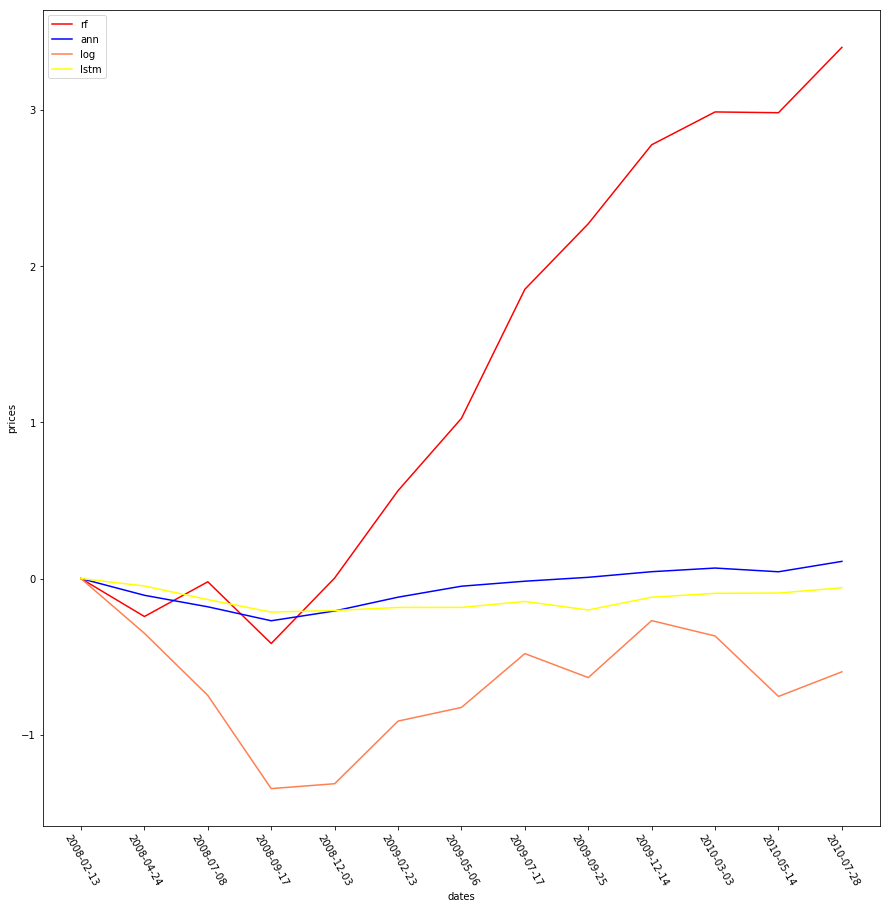

In [159]:
init = 1

plt.figure(figsize = (15, 15))


plt.xticks(rotation = -60)
all_returns = [returns_rf, returns_ann, returns_log, returns_lstm]
all_dates=  [dates_rf, dates_ann, dates_log, dates_lstm]
all_legends=  ['rf', 'ann', 'log', 'lstm', 'mkt']
all_colors = ['red', 'blue', 'coral', 'yellow', 'black']
for j in range(4):
    curprice = init
    prices = []
    prices.append(curprice)
    for i in all_returns[j][1:]:
        curprice += curprice * i 
        prices.append(curprice)
    plt.plot(all_dates[j][:int(len(all_dates[j])/4):50], np.log(prices[:int(len(all_dates[j])/4):50]),label = all_legends[j], color=all_colors[j])
plt.legend(loc='upper left')
plt.ylabel('prices')
plt.xlabel('dates')
plt.savefig('model_comparison.png')
plt.show()

return:  0.0141791907595
1.91970962576


return:  0.00233098497484
1.09511546246


return:  -0.000311242216989
0.981376973358


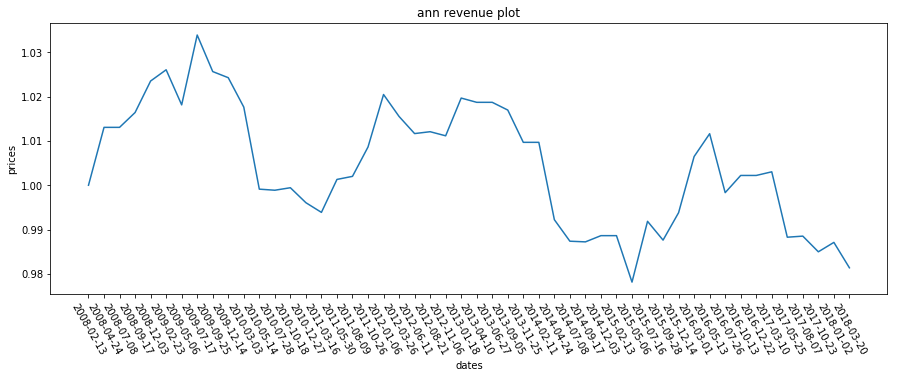

return:  -0.000542017779962
0.971836568724


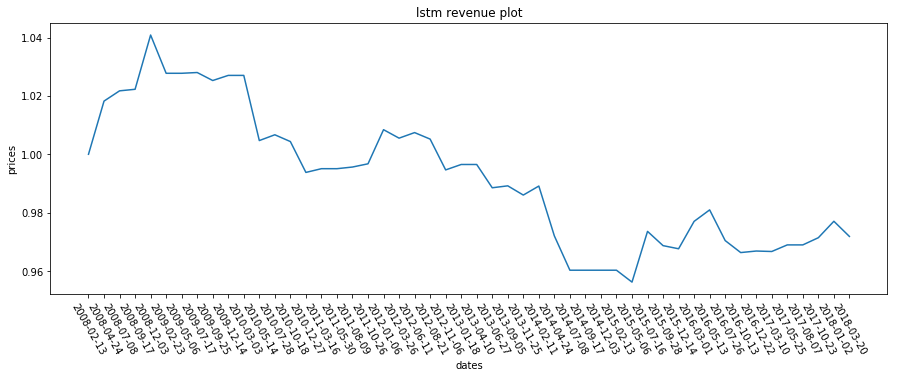

In [149]:
get_plot(1, returns_rf[::50], dates_rf[::50], 'random forest revenue plot', True)
get_plot(1, returns_log[::50], dates_log[::50], 'logistic regression revenue plot', True)
get_plot(1, returns_ann[::50], dates_ann[::50], 'ann revenue plot', True)
get_plot(1, returns_lstm[::50], dates_lstm[::50], 'lstm revenue plot', True)

# Get a,b,v panels

In [17]:
def prices(returns, base):
    # Converts returns into prices
    s = [base]
    for i in range(len(returns)):
        s.append(base * (1 + returns[i]))
    return np.array(s)

def lpm(returns, threshold, order):
    # This method returns a lower partial moment of the returns
    # Create an array he same length as returns containing the minimum return threshold
    threshold_array = np.empty(len(returns))
    threshold_array.fill(threshold)
    # Calculate the difference between the threshold and the returns
    diff = threshold_array - returns
    # Set the minimum of each to 0
    diff = diff.clip(min=0)
    # Return the sum of the different to the power of order
    return np.sum(diff ** order) / len(returns)

def var(returns, alpha):
    # This method calculates the historical simulation var of the returns
    sorted_returns = np.sort(returns)
    # Calculate the index associated with alpha
    index = int(alpha * len(sorted_returns))
    # VaR should be positive
    return abs(sorted_returns[index])
def cvar(returns, alpha):
    # This method calculates the condition VaR of the returns
    sorted_returns = np.sort(returns)
    # Calculate the index associated with alpha
    index = int(alpha * len(sorted_returns))
    # Calculate the total VaR beyond alpha
    sum_var = sorted_returns[0]
    for i in range(1, index):
        sum_var += sorted_returns[i]
    # Return the average VaR
    # CVaR should be positive
    return abs(sum_var / index)
def sortino_ratio(er, returns, rf = 0, target=0):
    return (er - rf) / math.sqrt(lpm(returns, target, 2))
def dd(returns, tau):
    # Returns the draw-down given time period tau
    values = prices(returns, 100)
    pos = len(values) - 1
    pre = pos - tau
    drawdown = float('+inf')
    # Find the maximum drawdown given tau
    while pre >= 0:
        dd_i = (values[pos] / values[pre]) - 1
        if dd_i < drawdown:
            drawdown = dd_i
        pos, pre = pos - 1, pre - 1
    # Drawdown should be positive
    return abs(drawdown)
def max_dd(returns):
    # Returns the maximum draw-down for any tau in (0, T) where T is the length of the return series
    max_drawdown = float('-inf')
    for i in range(0, len(returns)):
        drawdown_i = dd(returns, i)
        if drawdown_i > max_drawdown:
            max_drawdown = drawdown_i
    # Max draw-down should be positive
    return abs(max_drawdown)


In [8]:
def get_stat_a(returns):
    df = pd.DataFrame(returns)
    m = np.average(returns)
    std = np.std(returns)
    ste = std/np.sqrt(len(returns))
    t_stat = m/ste
    median = np.median(returns)
    q1 = np.percentile(returns,25)
    q3 = np.percentile(returns,75)
    hit_ratio = len(np.array(returns)[np.array(returns) > 0] )/len(returns)
    maximum = max(returns)
    minimum = min(returns)
    skew = df.skew()[0]
    kurt = df.kurt()[0]
    return [m,ste,t_stat,minimum,q1,median,q3,maximum,hit_ratio,std,skew,kurt]
def get_stat_b(returns):
    from scipy.stats import norm
    VaR1 = var(returns, 0.01)
    VaR5 = var(returns, 0.05)
    CVaR1 = cvar(returns, 0.01)
    CVaR5 = cvar(returns, 0.05)
    return [VaR1, CVaR1, VaR5, CVaR5,max_dd(returns)]
def get_stat_c(returns):
    pa_returns, sharp_ratios = [], []
    sortino_ratios, stds, dstds, ers = [],[],[],[]
    i = 0
    
    while i < len(returns):
        annual_return = returns[i:i+250]
        dstd = np.std(np.array(annual_return)[np.array(annual_return) < 0])
        annual_profit = [i+1 for i in annual_return]
        pa_return = np.array(annual_profit).cumprod()[-1]
        m = np.average(annual_return)
        std = np.std(annual_return)
        sharp_ratio = (m*np.sqrt(250))/std
        sortino_ratio = (m*np.sqrt(250))/dstd
        sharp_ratios.append(sharp_ratio)
        sortino_ratios.append(sortino_ratio)
        stds.append(std)
        dstds.append(dstd)
        i+=250
    return [np.average(pa_returns),np.average(stds),np.average(dstds), np.average(sharp_ratios),np.average(sortino_ratios)]

In [54]:
label_a_1 = ['Mean return','Standard error','t-statistic','Minimum','Quartile 1','Median','Quartile 3']
label_a_2 = ['Maximum','Share > 0','Standard dev.','Skewness','Kurtosis']
label_a = label_a_1 + label_a_2
panel_A = pd.DataFrame(index = label_a)
dapan = get_price('399001.XSHE')['close']
returns_mkt = ((dapan - dapan.shift(1))/dapan).dropna( how = 'any')
panel_A['MKT'] = get_stat_a(returns_mkt)
panel_A['RAF'] = get_stat_a(returns)

panel_A['LOG'] = get_stat_a(returns_log)

In [12]:
label_a_1 = ['Mean return','Standard error','t-statistic','Minimum','Quartile 1','Median','Quartile 3']
label_a_2 = ['Maximum','Share > 0','Standard dev.','Skewness','Kurtosis']
label_a = label_a_1 + label_a_2
panel_A = pd.DataFrame(index = label_a)
panel_A['ANN'] = get_stat_a(returns_ann)

In [20]:
panel_C['ANN'] = get_stat_c(returns_ann)
panel_C.to_csv('Panel C_ANN.csv')

/home/dell/anaconda3/envs/Fintech/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/dell/anaconda3/envs/Fintech/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [89]:
panel_A.to_csv('Panel A.csv')

In [15]:
label_b = ['1-percent VaR','1-percent CVaR', '5-percent VaR','5-percent CVaR', 'Max Drawdown']
panel_B = pd.DataFrame(index = label_b)
panel_B['MKT'] = get_stat_b(returns_mkt)
panel_B['RAF'] = get_stat_b(returns)
panel_B['LOG'] = get_stat_b(returns_log)

In [88]:
panel_B.to_csv('Panel B.csv')

In [19]:
label_c = ['p.a.Return', 'Standard Dev.','Downside Dev.','p.a.Sharpe ratio', 'p.a.Sortino ratio']
panel_C= pd.DataFrame(index = label_c)
panel_C['MKT'] = get_stat_c(returns_mkt)
panel_C['RAF'] = get_stat_c(returns)
panel_C['LOG'] = get_stat_c(returns_log)

In [90]:
panel_C.to_csv("Panel C.csv")

In [ ]:
dapan = get_price('399001.XSHE')['close']
returns = ((dapan - dapan.shift(1))/dapan).dropna( how = 'any')
df = pd.DataFrame(returns)
m = np.average(returns)
std = np.std(returns)
ste = std/np.sqrt(len(returns))
t_stat = m/ste
median = np.median(returns)
q1 = np.percentile(returns,25)
q3 = np.percentile(returns,75)
hit_ratio = len(np.array(returns)[np.array(returns) > 0] )/len(returns)
maximum = max(returns)
minimum = min(returns)
skew = df.skew()[0]
kurt = df.kurt()[0]
log_stats_a = [m,ste,t_stat,minimum,q1,median,q3,maximum,hit_ratio,std,skew,kurt]
label_a_1 = ['Mean return','Standard error','t-statistic','Minimum','Quartile 1','Median','Quartile 3']
label_a_2 = ['Maximum','Share > 0','Standard dev.','Skewness','Kurtosis']
label_a = label_a_1 + label_a_2
panel_A = pd.DataFrame(index = label_a)
panel_A['MKT'] = log_stats_a

In [91]:
panel_A

MKT        RAF       LOG
Mean return    -0.000628   0.011438  0.000217
Standard error  0.000942   0.000574  0.000533
t-statistic    -0.666569  19.939605  0.407662
Minimum        -0.072152  -0.110824 -0.111106
Quartile 1     -0.007417  -0.004841 -0.012391
Median         -0.000715   0.011524  0.002041
Quartile 3      0.006765   0.028010  0.015672
Maximum         0.040749   0.091170  0.151264
Share > 0       0.485356   0.683936  0.537751
Standard dev.   0.014568   0.028623  0.026598
Skewness       -0.563184  -0.176974 -0.573629
Kurtosis        2.809978   1.105529  2.270824

In [92]:
panel_C

MKT        RAF       LOG
p.a.Return              NaN        NaN       NaN
Standard Dev.      0.014568   0.026187  0.025160
Downside Dev.      0.010857   0.016620  0.017754
p.a.Sharpe ratio  -0.681736   6.804771  0.526319
p.a.Sortino ratio -0.914701  11.860618  0.784132

In [93]:
panel_B

MKT       RAF       LOG
1-percent VaR   0.039275  0.069747  0.088732
1-percent CVaR  0.063997  0.084120  0.096230
5-percent VaR   0.025204  0.035728  0.045049
5-percent CVaR  0.036361  0.054918  0.069078
Max Drawdown    0.100961  0.185056  0.227898

In [21]:
returns_rf, dates_rf = 

NameError: name 'returns' is not defined